In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/transformed/final_dataframe.csv', index_col=0)

In [3]:
class GameCell(tf.keras.layers.Layer):

    def __init__(self, states, teams, lines_len, scores_len):
        super(GameCell, self).__init__()
        self.states = states
        self.teams = teams
        self.lines_len = lines_len
        self.scores_len = scores_len
        self.state_size = tf.TensorShape([teams, states])

    def build(self, input_shape ):
        self.Bz = self.add_weight(
            shape=[self.states*2, 4 + self.lines_len + self.scores_len])
        self.Br = self.add_weight(
            shape=[self.states*2, 4 + self.lines_len + self.scores_len])
        self.Bm = self.add_weight(
            shape=[self.states*2, 4 + self.lines_len + self.scores_len])
        self.Az = self.add_weight(
            shape=[self.states*2, self.states*2],) 
            # initializer=tf.keras.initializers.Identity(gain=0.25))
        self.Ar = self.add_weight(
            shape=[self.states*2, self.states*2],)
            # initializer=tf.keras.initializers.Identity(gain=0.25))
        self.Am = self.add_weight(
            shape=[self.states*2, self.states*2],)
            # initializer=tf.keras.initializers.Identity(gain=0.25))
        self.dz = self.add_weight(
            shape=[self.states*2, 1],)
            # initializer=tf.keras.initializers.Zeros)
        self.dr = self.add_weight(
            shape=[self.states*2, 1],)
            # initializer=tf.keras.initializers.Ones())
        self.dm = self.add_weight(
            shape=[self.states*2, 1],)
            # initializer=tf.keras.initializers.Zeros)
        super(GameCell, self).build(input_shape)
    
    def call(self, inputs, state):
        teams, u = inputs
        u = tf.reshape(u, (-1, 1))
        state = state[0]
        x_k = self._get_state(state, teams)
        x_kp = self._gru(u, x_k)
        state = self._update_state(state, teams, x_kp, x_k)
        state = tf.reshape(state, (1, state.shape[0], state.shape[1]))
        return state, [state]

    def _gru(self, u, x):
        z = self.Az @ x + self.Bz @ u + self.dz
        z = tf.math.sigmoid(z)
        r = self.Ar @ x + self.Br @ u - self.dr
        r = tf.math.sigmoid(r)
        m = self.Am @ (r * x) + self.Bm @ u + self.dm
        m = tf.math.tanh(m)
        return z * x + (1-z) * m

    @staticmethod
    def _get_state(state, teams):
        states = tf.gather_nd(state[0], teams)
        return tf.reshape(states, (-1, 1))
    
    @staticmethod
    def _update_state(state, teams, x_kp, x_k):
        dx = x_kp - x_k
        dx = tf.reshape(dx, (2, -1))
        indices = tf.reshape(teams, (2, 1))
        return state[0] + tf.scatter_nd(indices, dx, state[0].shape)

class GameRNN(tf.keras.layers.RNN):
    
    def __init__(self, states, teams, lines_len, scores_len, 
                 return_sequences=True, return_state=False,
                 stateful=True, unroll=False):
        cell = GameCell(states, teams, lines_len, scores_len)
        super(GameRNN, self).__init__(cell, 
            return_sequences=return_sequences, return_state=return_state,
            stateful=stateful, unroll=unroll)
        
    def call(self, inputs, initial_state=None, constants=None):
        return super(GameRNN, self).call(
            inputs, initial_state=initial_state, constants=constants)

In [4]:
class PredictionLayer(tf.keras.layers.Layer):

    def __init__(self, states, predictions=2):
        super(PredictionLayer, self).__init__()
        self.states = states
        self.predictions = predictions

    def build(self, input_shape):
        self.C = self.add_weight(
            shape=[self.predictions, self.states*2])
        self.D = self.add_weight(
            shape=[self.predictions, 6])
        self.const = self.add_weight(
            shape=[self.predictions, 1])
        super(PredictionLayer, self).build(input_shape)

    def call(self, inputs):
        u_kp, state, teams = inputs
        u_kp = tf.expand_dims(u_kp, axis=-1)[0]
        x_kp = self._get_state(state, teams)
        Cx = tf.transpose(tf.tensordot(self.C, x_kp, axes=[[1], [1]]), perm=[1, 0, 2])
        Du = tf.transpose(tf.tensordot(self.D, u_kp, axes=[[1], [1]]), perm=[1, 0, 2])
        return tf.expand_dims(Cx + Du + self.const, axis=0)

    @staticmethod
    def _get_state(state, teams):
        seq_len = teams.shape[1]
        seq_len_range = tf.expand_dims(
            tf.range(seq_len, dtype=tf.int32), axis=1)
        home_indices = tf.concat((seq_len_range, teams[0, :, 0]), axis=1)
        visitor_indices = tf.concat((seq_len_range, teams[0, :, 1]), axis=1)
        state_home = tf.gather_nd(state[0], home_indices)
        state_visitor = tf.gather_nd(state[0], visitor_indices)
        state_teams = tf.concat((state_home, state_visitor), axis=1)
        return tf.expand_dims(state_teams, axis=-1)

In [5]:
def build_model(seq_len, states, teams, lines_len=4, scores_len=8):
    
    teams_k = tf.keras.layers.Input(batch_shape=(1, seq_len, 2, 1), dtype=tf.int32)
    days_off_k = tf.keras.layers.Input(batch_shape=(1, seq_len, 4))
    lines_k = tf.keras.layers.Input(batch_shape=(1, seq_len, lines_len))
    scores_k = tf.keras.layers.Input(batch_shape=(1, seq_len, scores_len))

    u_k = tf.keras.layers.concatenate([days_off_k, lines_k, scores_k])

    x_kp = GameRNN(states, teams, lines_len, scores_len)(tuple([teams_k, u_k]))

    teams_kp = tf.keras.layers.Input(batch_shape=(1, seq_len, 2, 1), dtype=tf.int32)
    days_off_kp = tf.keras.layers.Input(batch_shape=(1, seq_len, 4))
    lines_kp = tf.keras.layers.Input(batch_shape=(1, seq_len, 2))

    u_kp = tf.keras.layers.concatenate([days_off_kp, lines_kp])

    preds = PredictionLayer(states)([u_kp, x_kp, teams_kp])
    preds = tf.keras.layers.Reshape((seq_len, -1))(preds)
    preds = tf.keras.layers.Activation('sigmoid')(preds)

    score_preds = PredictionLayer(states)([u_kp, x_kp, teams_kp])
    score_preds = tf.keras.layers.Reshape((seq_len, -1))(score_preds)

    return tf.keras.Model(
        inputs=[teams_k, days_off_k, lines_k, scores_k, teams_kp, days_off_kp, lines_kp],
        outputs=[preds, score_preds])

In [6]:
df[['home_team', 'visitor_team']] = df[['home_team', 'visitor_team']].astype('category')
df['home_team_cat'] = df['home_team'].cat.codes
df['visitor_team_cat'] = df['visitor_team'].cat.codes
df['home_final'] = df[[col for col in df.columns if 'H ' in col]].sum(axis=1)
df['visitor_final'] = df[[col for col in df.columns if 'V ' in col]].sum(axis=1)
scaled_scores = StandardScaler().fit_transform(df[['home_final', 'visitor_final']])
df['home_final_scaled'] = scaled_scores[:, 0]
df['visitor_final_scaled'] = scaled_scores[:, 1]

In [7]:
seq_len = 100
state_size = 6
teams = len(df['visitor_team'].cat.categories)
line_used = 'open'

In [8]:
def map_to_cat(x, categories):
    if x == categories[0]:
        return 1
    elif x == categories[1]:
        return 0
    else:
        return 0.5

In [9]:
df['open_spread_win_cat'] = df['open_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['close_spread_win_cat'] = df['close_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['open_total_win_cat'] = df['open_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))
df['close_total_win_cat'] = df['close_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))

In [10]:
train = range(27, 6827)
test = range(6827, len(df)-1)

seq_start = [len(train)%seq_len + seq_len*i for i in range(len(train)//seq_len)]
time_series_train = [range(start, start+seq_len) for start in seq_start]
time_series_plus_train = [range(start+1, start+1+seq_len) for start in seq_start]
seq_start_test = [test[0] + seq_len*i for i in range(len(test)//seq_len)]
time_series_test = [range(start, start+seq_len) for start in seq_start_test]
time_series_plus_test = [range(start+1, start+1+seq_len) for start in seq_start_test]

In [11]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for r in time_series_list:
        tensor_list += [tensor[r]]
    return np.stack(tensor_list)

In [12]:
cols = ['home_team_cat', 'visitor_team_cat']
teams_train = convert_to_time_series(
    df[cols].values, time_series_train).astype(np.int32)
teams_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train).astype(np.int32)
teams_test = convert_to_time_series(
    df[cols].values, time_series_test).astype(np.int32)
teams_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test).astype(np.int32)

In [13]:
cols = ['home_days_since_home', 'home_days_since_away', 'visitor_days_since_home', 'visitor_days_since_away']
days_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = days_scaled[:, i]

days_off_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
days_off_plus_train = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_train)
days_off_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)
days_off_plus_test = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_test)

In [14]:
cols = ['home_score_open', 'visitor_score_open', 'home_score_close', 'visitor_score_close']
lines_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = lines_scaled[:, i]

lines_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
lines_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = [col for col in scaled_cols if line_used in col]
lines_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
lines_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

In [15]:
cols = ['H 1st', 'H 2nd', 'H 3rd', 'H 4th', 'V 1st', 'V 2nd', 'V 3rd', 'V 4th']
scores_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = scores_scaled[:, i]

scores_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
scores_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = ['home_final_scaled', 'visitor_final_scaled']
scores_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
scores_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

cols = ['open_spread_win_cat', 'open_total_win_cat', 'close_spread_win_cat', 'close_total_win_cat']
cols = [col for col in cols if line_used in col]
outcomes_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
outcomes_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

In [16]:
model = build_model(seq_len, state_size, teams)

W1204 18:35:15.932869 20324 deprecation.py:506] From C:\Users\rcpat\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1, 100, 4)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 100, 4)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, 100, 8)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(1, 100, 4)]        0                                            
______________________________________________________________________________________________

In [19]:
opt = tf.keras.optimizers.Adam(lr=0.005)
model.compile(
    optimizer=opt, loss=['binary_crossentropy', 'mean_squared_error'], metrics=['accuracy']
)
# model.compile(
#     optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']
# )
epochs = 20

In [20]:
for i in range(epochs):
    print('Epoch {}'.format(str(i+1)))
    model.reset_states()
    model.fit(
        x=[np.expand_dims(teams_train, axis=-1), days_off_train, lines_train, scores_train, 
        np.expand_dims(teams_plus_train, axis=-1), days_off_plus_train, lines_plus_train],
        y=[outcomes_plus_train, scores_plus_train.astype(np.float32)],
        batch_size=1,
        epochs=1,
        verbose=1
    )

Epoch 1
68/68 [==============================] - 6s 82ms/sample - loss: 3.4798 - activation_loss: 0.8419 - reshape_1_loss: 2.6379 - activation_accuracy: 0.4885 - reshape_1_accuracy: 0.4846
Epoch 2
68/68 [==============================] - 5s 67ms/sample - loss: 2.0227 - activation_loss: 0.7481 - reshape_1_loss: 1.2746 - activation_accuracy: 0.4864 - reshape_1_accuracy: 0.4974
Epoch 3
68/68 [==============================] - 5s 73ms/sample - loss: 1.7193 - activation_loss: 0.7187 - reshape_1_loss: 1.0007 - activation_accuracy: 0.4860 - reshape_1_accuracy: 0.5304
Epoch 4
68/68 [==============================] - 6s 81ms/sample - loss: 1.5948 - activation_loss: 0.7059 - reshape_1_loss: 0.8889 - activation_accuracy: 0.4880 - reshape_1_accuracy: 0.5769
Epoch 5
68/68 [==============================] - 5s 78ms/sample - loss: 1.5068 - activation_loss: 0.7010 - reshape_1_loss: 0.8058 - activation_accuracy: 0.4922 - reshape_1_accuracy: 0.6044
Epoch 6
68/68 [==============================] - 6s 81m

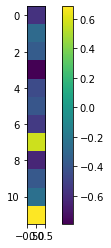

In [21]:
plt.imshow(model.layers[8].get_weights()[8])
plt.colorbar()

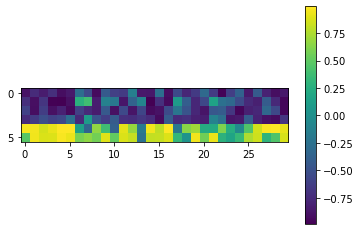

In [22]:
plt.imshow(model.layers[8].states[0][0].numpy().T)
plt.colorbar()

In [23]:
import copy
states = copy.deepcopy(model.layers[8].states)

In [24]:
model.layers[8].reset_states(states[0].numpy())

In [25]:
preds = []
score_preds = []
for batch in range(teams_test.shape[0]):
    line_preds, score_preds_ = model.predict(
        [np.expand_dims(teams_test, axis=-1)[batch: batch+1], 
            days_off_test[batch: batch+1], 
            lines_test[batch: batch+1], scores_test[batch: batch+1], 
            np.expand_dims(teams_plus_test, axis=-1)[batch: batch+1], 
            days_off_plus_test[batch: batch+1], lines_plus_test[batch: batch+1]])
    print(model.layers[8].states[0].numpy()[0,10])
    preds += [line_preds]
    score_preds += [score_preds_]

[-0.7116869   0.9595886   0.35256064 -0.6860815  -0.769099   -0.8962932 ]
[-0.7675233   0.8615198  -0.7921489  -0.88760704 -0.98116356 -0.9686023 ]
[-0.6748233   0.9961122   0.70509875 -0.54701465 -0.99624395 -0.9147067 ]
[-0.7590969   0.90654385 -0.826599   -0.3487237  -0.96418154 -0.75639904]
[-0.44542047  0.9507402  -0.49542063 -0.9414594  -0.95804095 -0.86777645]


In [26]:
score_preds = np.squeeze(np.stack(score_preds)).reshape(-1, 2)

In [27]:
preds = np.squeeze(np.stack(preds)).reshape(-1, 2)

(array([[  5.,  13.,  46.,  98., 119., 127.,  64.,  19.,   8.,   1.],
        [  8.,  19.,  64.,  91., 101., 111.,  65.,  28.,  11.,   2.]]),
 array([0.39069992, 0.41257283, 0.4344457 , 0.45631862, 0.4781915 ,
        0.5000644 , 0.5219373 , 0.5438102 , 0.56568307, 0.587556  ,
        0.6094289 ], dtype=float32),
 <a list of 2 BarContainer objects>)

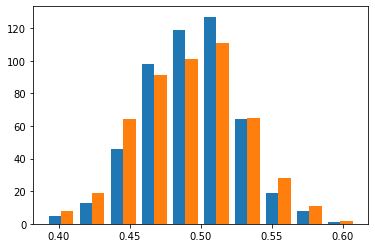

In [28]:
plt.hist(preds)

In [29]:
mean_ = df[['home_final', 'visitor_final']].mean(axis=0).values
std_ = df[['home_final', 'visitor_final']].std(axis=0).values

In [30]:
score_preds = score_preds * std_ + mean_

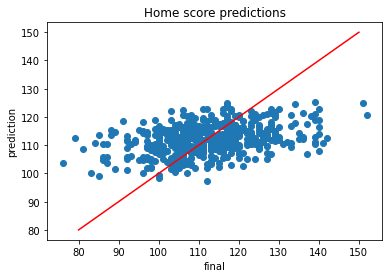

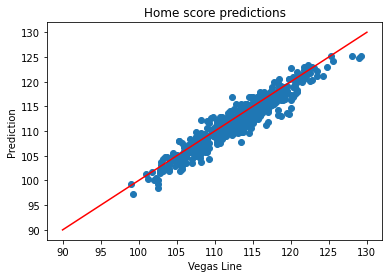

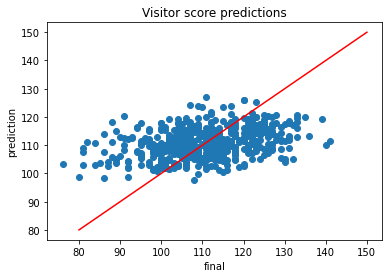

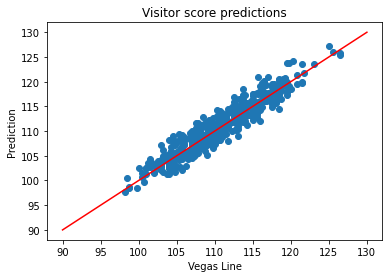

In [31]:
plt.scatter(df['home_final'][-500:], score_preds[:, 0])
plt.plot([80, 150], [80, 150], 'red')
plt.xlabel('final')
plt.ylabel('prediction')
plt.title('Home score predictions')
plt.show()

plt.scatter(df['home_score_open'][-500:], score_preds[:, 0])
plt.plot([90, 130], [90, 130], 'red')
plt.xlabel('Vegas Line')
plt.ylabel('Prediction')
plt.title('Home score predictions')
plt.show()

plt.scatter(df['visitor_final'][-500:], score_preds[:, 1])
plt.plot([80, 150], [80, 150], 'red')
plt.xlabel('final')
plt.ylabel('prediction')
plt.title('Visitor score predictions')
plt.show()

plt.scatter(df['visitor_score_open'][-500:], score_preds[:, 1])
plt.plot([90, 130], [90, 130], 'red')
plt.xlabel('Vegas Line')
plt.ylabel('Prediction')
plt.title('Visitor score predictions')
plt.show()

In [32]:
df['final_spread'] = df['home_final'] - df['visitor_final']
df['final_total'] = df['home_final'] + df['visitor_final']

In [33]:
df['final_margin_from_open_spread'] = df['final_spread'] - (df['home_score_open'] - df['visitor_score_open'])
df['final_margin_from_open_total'] = df['final_total'] - (df['home_score_open'] + df['visitor_score_open'])

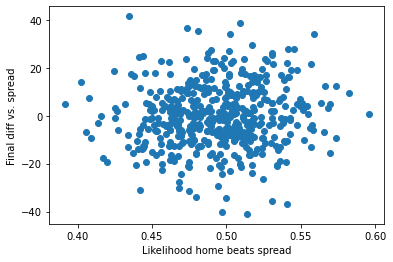

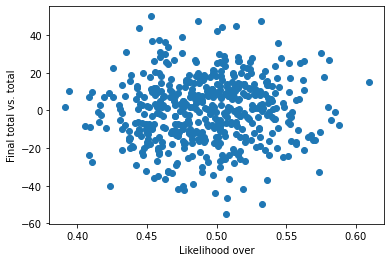

In [34]:
plt.scatter(preds[:, 0], df['final_margin_from_open_spread'][-500:])
plt.xlabel('Likelihood home beats spread')
plt.ylabel('Final diff vs. spread')
plt.show()

plt.scatter(preds[:, 1], df['final_margin_from_open_total'][-500:])
plt.xlabel('Likelihood over')
plt.ylabel('Final total vs. total')
plt.show()

In [35]:
spread_wins = len(np.where((preds[:, 0] > 0.5) & (df['final_margin_from_open_spread'][-500:] > 0))[0])
spread_wins += len(np.where((preds[:, 0] < 0.5) & (df['final_margin_from_open_spread'][-500:] < 0))[0])
den = 500 - len(np.where(df['final_margin_from_open_spread'][-500:] == 0)[0])
win_fraction = spread_wins / den
win_fraction

0.5436105476673428

In [36]:
total_wins = len(np.where((preds[:, 1] > 0.5) & (df['final_margin_from_open_total'][-500:] > 0))[0])
total_wins += len(np.where((preds[:, 1] < 0.5) & (df['final_margin_from_open_total'][-500:] < 0))[0])
den = 500 - len(np.where(df['final_margin_from_open_total'][-500:] == 0)[0])
win_fraction = total_wins / den
win_fraction

0.5140562248995983